In [1]:
#Loading important libraries
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV 
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble import partial_dependence

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
#Reading the data
data = pd.read_csv('conversion_data.csv')

In [4]:
#Head of data
data.head(5)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [5]:
#Understanding the data
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [6]:
#Some quick observations
#The users for this site is fairly young with a mean age of about 30 years
#There seems to be some data inconsistency. The maximum age is indicated to be 123 years. 
#68% of the users are new and only less that 32% are return users
#The average number of pages visited by a user in one session is around 4.8 pages
#Total number of users that convert is around 3% which seems reasonable as it is the industry standard.

In [7]:
#investigating country and source columns
data['country'].describe()

count     316200
unique         4
top           US
freq      178092
Name: country, dtype: object

In [8]:
data['source'].describe()

count     316200
unique         3
top          Seo
freq      155040
Name: source, dtype: object

In [9]:
data.groupby('country').count() 

,age,new_user,source,total_pages_visited,converted
country,,,,,
China,76602,76602,76602,76602,76602
Germany,13056,13056,13056,13056,13056
UK,48450,48450,48450,48450,48450
US,178092,178092,178092,178092,178092


In [10]:
#Highest traffic for the site comes from US, followed by China and UK
#This indicates it's probably a US based site

In [11]:
#Checking for data inconsistencies
data.sort_values(by = 'age', ascending = False).head(10)

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1
265167,US,79,1,Direct,1,0
192644,US,77,0,Direct,4,0
154217,US,73,1,Seo,5,0
208969,US,72,1,Direct,4,0
301366,UK,70,0,Ads,5,0
114485,US,70,1,Ads,9,0
57122,UK,69,1,Direct,4,0
290142,US,69,1,Seo,6,0


In [12]:
#Its evident that there are only two rows with probably wrong data entered.
#The next course of action is one of two things
#1. Remove both these rows
#2. Fill these rows with a substituted value such as mean age etc

#It's safer to remove the entire row

In [13]:
data.drop([90928,295581], axis = 0).sort_values(by = 'age', ascending = False).head(7)

,country,age,new_user,source,total_pages_visited,converted
265167,US,79,1,Direct,1,0
192644,US,77,0,Direct,4,0
154217,US,73,1,Seo,5,0
208969,US,72,1,Direct,4,0
114485,US,70,1,Ads,9,0
301366,UK,70,0,Ads,5,0
57122,UK,69,1,Direct,4,0


In [14]:
#The inconsistent data points have been removed

In [15]:
#Exploratory data analysis to get a sense of the data
#Conversion rate by countries

data_country = data.groupby('country')[['converted']].mean()

In [16]:
#Plotting the above dataframe

data_country.head(5)

,converted
country,
China,0.001332
Germany,0.062500
UK,0.052632
US,0.037801


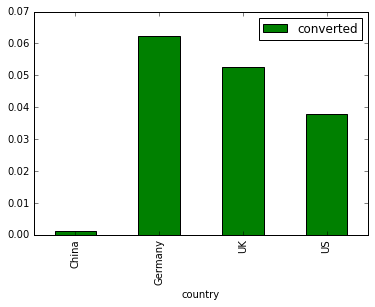

In [17]:
data_country.plot(kind = 'bar', color = 'g')

In [18]:
#Some quick takeaways
#Although Germany seems to have the lowest traffic, it still seems to maintain the highest conversion rate
#This is true of UK as well.
#However, it is interesting to note that, China has a very low conversion rate. Much lesser than the other three countries
#Let's look into this further

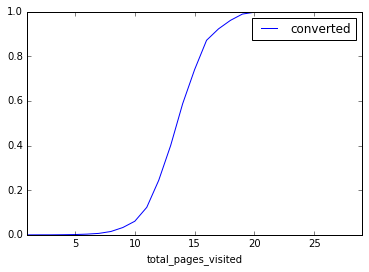

In [19]:
#Plotting total pages visited
#This plot is as expected. As the number of pages visited increases, the conversion rate increases as well
data.groupby('total_pages_visited')[['converted']].mean().plot(kind = 'line', color = 'b')

In [20]:
#Looking into China
#Mean age of chinese users
data.groupby('country')[['age']].describe()

age
country                     
China   count   76602.000000
        mean       30.672972
        std         8.283862
        min        17.000000
        25%        24.000000
        50%        30.000000
        75%        36.000000
        max        69.000000
Germany count   13056.000000
        mean       30.449985
        std         8.289022
        min        17.000000
        25%        24.000000
        50%        30.000000
        75%        36.000000
        max       123.000000
UK      count   48450.000000
        mean       30.451538
        std         8.244991
        min        17.000000
        25%        24.000000
        50%        30.000000
        75%        36.000000
        max       111.000000
US      count  178092.000000
        mean       30.566482
        std         8.272128
        min        17.000000
        25%        24.000000
        50%        30.000000
        75%        36.000000
        max        79.000000

In [21]:
#Roughly the mean age of chinese users is on par with the mean age of users in other countries
#Hence, this is probably not the cause for their low conversion

In [22]:
#Number of pages visited by an average Chinese user
data.groupby('country').mean()

,age,new_user,total_pages_visited,converted
country,,,,
China,30.672972,0.698520,4.553523,0.001332
Germany,30.449985,0.677237,5.190717,0.062500
UK,30.451538,0.679835,5.082167,0.052632
US,30.566482,0.681985,4.930160,0.037801


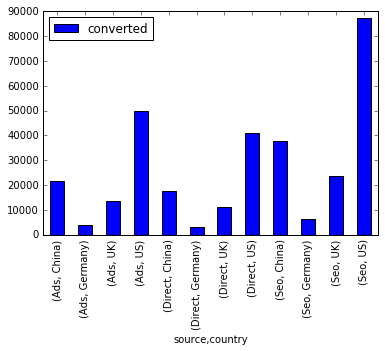

In [23]:
#Users' from ads
df_analysis = data.groupby(['source','country'])[['converted']].count()
df_analysis.plot(kind = 'bar')

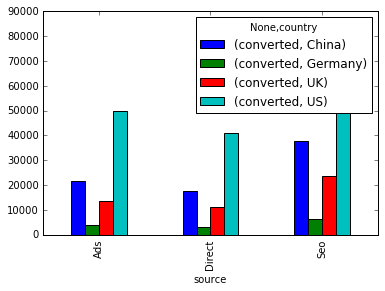

In [24]:
#Absolute numbers
df_analysis.unstack('country').plot(kind = 'bar')

In [25]:
#percentages
df_analysis.unstack('country')

converted                      
country     China Germany     UK     US
source                                 
Ads         21561    3760  13518  49901
Direct      17463    2864  11131  40962
Seo         37578    6432  23801  87229

In [26]:
def f(x):
    y = Series([0,0,0])
    for i in np.arange(3):
        y[i] = 100 * x[i]/sum(x)
    return y

df_analysis.unstack('country').apply(f, axis = 0)

converted                
country     China Germany  UK  US
0              28      28  27  28
1              22      21  22  23
2              49      49  49  48

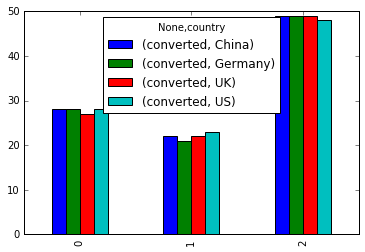

In [27]:
df_analysis.unstack('country').apply(f, axis = 0).plot(kind = 'bar')

In [28]:
#From the above table, it is evident that the conversion from seo is maximum for all countries.
#Also, the distribution of ads, seo and direct is comparable for all countries

#We have eliminated all the obvious reasons why China might be converting poorly. 
#From this analysis it can be said that, data from Chinese users is very similar to the ones from other users 

#We need to look into it even further. 

In [29]:
#Delving into Machine Learning

data.head(5)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [30]:
data.columns.values

array(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'], dtype=object)

In [31]:
#The response variable
y = data['converted']
y.head(5)

0    0
1    0
2    0
3    0
4    0
Name: converted, dtype: int64

In [32]:
#The features
X = data[data.columns.values[:-1]]
X.head(5)

,country,age,new_user,source,total_pages_visited
0,UK,25,1,Ads,1
1,US,23,1,Seo,5
2,US,28,1,Seo,4
3,China,39,1,Seo,5
4,US,30,1,Seo,6


In [33]:
#creating labels for country and source in the features data
lb = LabelEncoder()
X['country'] = lb.fit_transform(X['country'])
X['source'] = lb.fit_transform(X['source'])
X.head(5)

C:\Users\Deepak\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Deepak\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,country,age,new_user,source,total_pages_visited
0,2,25,1,0,1
1,3,23,1,2,5
2,3,28,1,2,4
3,0,39,1,2,5
4,3,30,1,2,6


In [34]:
#creating training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [35]:
#creating an instance of the estimator
pipeline = Pipeline(steps = [('clf', DecisionTreeClassifier(criterion = 'entropy'))])

In [36]:
#Hyper parameters for the grid search

parameters = [{
        'clf__max_depth': (150, 155, 160),
        'clf__min_samples_split': (1,2,3),
        'clf__min_samples_leaf': (1,2,3)
    }]

In [37]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs= -1, error_score= 0)

In [38]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=0,
       estimator=Pipeline(steps=[('clf', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'clf__max_depth': (150, 155, 160), 'clf__min_samples_leaf': (1, 2, 3), 'clf__min_samples_split': (1, 2, 3)}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [39]:
best_parameters = grid_search.best_estimator_.get_params()
best_parameters

{'clf': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=150,
             max_features=None, max_leaf_nodes=None, min_samples_leaf=3,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=None, splitter='best'),
 'clf__class_weight': None,
 'clf__criterion': 'entropy',
 'clf__max_depth': 150,
 'clf__max_features': None,
 'clf__max_leaf_nodes': None,
 'clf__min_samples_leaf': 3,
 'clf__min_samples_split': 2,
 'clf__min_weight_fraction_leaf': 0.0,
 'clf__presort': False,
 'clf__random_state': None,
 'clf__splitter': 'best',
 'steps': [('clf',
   DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=150,
               max_features=None, max_leaf_nodes=None, min_samples_leaf=3,
               min_samples_split=2, min_weight_fraction_leaf=0.0,
               presort=False, random_state=None, splitter='best'))]}

In [40]:
grid_search.best_params_

{'clf__max_depth': 150,
 'clf__min_samples_leaf': 3,
 'clf__min_samples_split': 2}

In [41]:
#Predictions
preds = grid_search.predict(X_test)
print classification_report(y_test, preds)

             precision    recall  f1-score   support

          0       0.99      1.00      0.99     76526
          1       0.82      0.65      0.73      2524

avg / total       0.98      0.98      0.98     79050



In [42]:
#Note
#Recall = sensitivity = TP/(TP + FN)
#Precision = TP/(TP + FP)
#Specificity = TN/(TN + FP) 

#From the above results we can conclude, recall = 0.66 and precision = 0.82
#This implies of all people who converted, we weren't able to identify 34% of them
#Similarly of all the people we identified would convert only 82% of them actually converted

#We need to improve sensitivity further

In [43]:
#Ensemble methods

pipeline = Pipeline(steps = [('clf', RandomForestClassifier(criterion = 'entropy'))])

In [44]:
clf_forest = RandomForestClassifier(n_estimators= 20, criterion = 'entropy', max_depth= 50, min_samples_leaf= 3,
                                    min_samples_split= 3, oob_score= True)

In [45]:
clf_forest.fit(X_train, y_train)

C:\Users\Deepak\Anaconda2\lib\site-packages\sklearn\ensemble\forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=3, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [46]:
preds = clf_forest.predict(X_test)
preds

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [47]:
print classification_report(y_test, preds)

             precision    recall  f1-score   support

          0       0.99      1.00      0.99     76526
          1       0.82      0.68      0.74      2524

avg / total       0.98      0.99      0.98     79050



In [48]:
#Precision has remained the same
#Sensitivity has improved by 3%

In [49]:
#Variable importance
clf_forest.feature_importances_

array([ 0.05732852,  0.08599696,  0.062577  ,  0.01257419,  0.78152333])

In [50]:
#Features used are 
data.columns.values[:-1]

array(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype=object)

In [51]:
#out of box score
clf_forest.oob_score_

0.98510647269660556

In [52]:
#Some insights
#From variable importance, it can be said that, total_pages_visited is the most important feature
#Also from oob score it can be said that oob error rate is close to 1.4%

#Out of box score is 98.5%. This implies, the predictions were right for 98.5% of the data set. However, it is useful to recognize
#that, the dataset is highly imbalanced with 97% of the data in class 0 and only 3% in class 1. This implies, even if we had
#classified everything as 0, the accuracy would still be 97%. Therefore, our predictions have only improved by 1.5% which is the
#difference of 98.5% and 97%

#The real challenge lies in improving the recall value of class 1. This value is close to 70%. This implies 30% of the customers
#who converted were not recognized by our system as potential customers. 

#Recall value needs to be improved even if that results in an increased overall error rate (decrease in precision) and a 
#decrease in specificity value. 

In [53]:
#Building RandomForest again
#This time without the total pages visited feature. 
#Also since, the classes are heavily imbalanced, giving it weights

X_new_train = X_train.copy()
X_new_test = X_test.copy()

In [54]:
X_new_train = X_new_train.drop('total_pages_visited', axis = 1)
X_new_test = X_new_test.drop('total_pages_visited', axis = 1)

In [55]:
clf_forest_new = RandomForestClassifier(n_estimators= 20, criterion = 'entropy', max_depth= 150, min_samples_leaf= 2,
                                    min_samples_split= 2, oob_score= True, class_weight = {0: 0.1, 1: 0.9})

In [56]:
clf_forest_new.fit(X_new_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 0.1, 1: 0.9},
            criterion='entropy', max_depth=150, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [57]:
preds = clf_forest_new.predict(X_new_test)
preds

array([1, 0, 0, ..., 0, 1, 1], dtype=int64)

In [58]:
print classification_report(y_test, preds)

             precision    recall  f1-score   support

          0       0.98      0.91      0.94     76526
          1       0.13      0.43      0.20      2524

avg / total       0.95      0.89      0.92     79050



In [59]:
clf_forest_new.feature_importances_

array([ 0.33711534,  0.23814308,  0.40888425,  0.01585733])

In [60]:
X_new_train.columns.values

array(['country', 'age', 'new_user', 'source'], dtype=object)

In [61]:
#Insights, although the error rate has gone up and the recall value has significantly crashed, from variable importance, we 
#can gather that new_user followed by country and age are the important variables with source having no effect on the outcome
#at all. 

In [62]:
#Some conclusions
#It is possible to predict upto 98.5% accuracy or an out of bag error rate of 1.5%
#Some of the important features are 1. Number of pages visited followed by 2. new_user, 3. country and 4. age
#Site is working very well for Germany and not so well for China
#This could be because of various reasons such as poor translation or the chineese site might be in English as well
#The site works well for younger people. Those less than 30 years of age. It could either be because of the nature of the site
#that caters only to young people or it could be possible that older people find it difficult to navigate through the site for a
#meaningful conversion
#Also, since the most important feature here is the number of pages visited, it implies that, if someone who has visited
#a lot of pages hasn't converted, then there is a good chance that the user will convert with a little bit of marketing such as
#discounts, benefits etc. 
#Also, users with an old account tend to do better than the ones with a new account. This could be used by marketing team to it's 
#advantage